# 13. Frame Selected Stability

In [1]:
from src import *

## Description

We look in this section for the stability of frame selected gradients across subjects (individual gradients approach) and also how stable the group gradients are when frame selecting compared to when full is used. 

GOAL: Evaluate differences of individual gradients of selected gradients and movie long gradients + evaluate differences of group gradients of selected timeseries and group gradients of full movies 

## Table of Contents
- [Frame selected (by discrete emotion timecourses) gradients](#discreteemo)
- [Frame selected (by 3FA timecourses) gradients](#3fa)

In [2]:
D = lambda x,y: ((x-y)**2).sum(axis=1)

<a class="anchor" id="discreteemo"></a>
## Frame selected (by discrete emotion timecourses) gradients

In [3]:
# In-Tervals percentages
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

### Gradients Computation

In [4]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

threshed_series = load('./resources/treshed_series.pkl')

1. Frame selection compute

In [56]:
for i in range(4):
    # individual variance variables
    fselect_subjects_gradients = {}
    
    threshed = threshed_series[i]
    for rng in tqdm(threshed.keys()):
        selected_series = threshed[rng]

        # concatenate on different frames across movies
        # basically doing reordering of columns
        tmp = next(iter(selected_series))
        subject_numbers = list(selected_series[tmp].keys())
        subject_tmpseries = {_id:[] for _id in subject_numbers}

        for mname in selected_series:
            if len(selected_series[mname]) == 0: continue
            for _id in subject_numbers:
                subject_tmpseries[_id].append(selected_series[mname][_id])

        subject_series = []
        for _id in subject_numbers:
            subject_series.append(np.concatenate(subject_tmpseries[_id]))

        # if concatenated length not long enough then skip whole process
        if len(subject_series[0]) < 15: 
            fselect_subjects_gradients[rng] = []
            continue

        # Compute individual gradients according to selected frames
        subjects_gradients = []
        for nsub in range(len(subject_numbers)):
            tmp_series = np.asarray(subject_series)[nsub]
            fc_selects = FC(tmp_series)
            g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                                kernel=aff_kernel, random_state=rs)
            g_selects.fit(fc_selects)
            subjects_gradients.append(g_selects.gradients_)

        # alignement across all gradients
        select_subjects_gradients,_,s = procrustes_align(np.asarray(subjects_gradients))
        select_subjects_gradients = np.asarray(select_subjects_gradients)
        fselect_subjects_gradients[rng] = select_subjects_gradients

    save('./resources/fselect_subjects_gradients{}.pkl'.format(i), fselect_subjects_gradients)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

2. Compute Null samples of various length

In [37]:
# Also doing sampling of a given percentage in each series equally 
# instead of over everything (so we necessarily have balanced per movie length)
bounds = {5:s5, 10: s10, 20: s20, 25:s25, 33:s33, 50:s50}
selected_series = load('./data/fmri_414_series.pkl')

for nullperc in [5,10,20]:
    TMP = []
    np.random.seed(19)
    
    for _ in tqdm(range(200)):
        normalize_subjects_gradients = {}
            
        # concatenate on different frames across movies
        # basically doing reordering of columns
        tmp = list(selected_series.values())
        subject_numbers = [l for l in list(tmp[0].keys())]
        bins = bounds[nullperc]
        
        
        bound_subject_tmpseries = {boun: {_id:[] for _id in subject_numbers} for boun in bins}

        for i in range(len(tmp)):
            if len(tmp[i]) == 0: continue

            length = tmp[i][subject_numbers[0]].shape[0]
#             sampleidx = np.random.choice(np.arange(length), 
#                                      length*nullperc//100, replace=False)  
            cur_idx = np.arange(length)
            np.random.shuffle(cur_idx)
            
            for boun in bins:
                for _id in subject_numbers:
                    lb,rb = boun
                    lb,rb = int(length * lb/100), int(length * rb/100)
                    shuffled_series = tmp[i][_id][cur_idx]
                    bound_subject_tmpseries[boun][_id].append(shuffled_series[lb:rb])

                
        for boun in bins:
            subject_tmpseries = bound_subject_tmpseries[boun]
            subject_series = []
            
            for _id in subject_numbers:
                sample = np.concatenate(subject_tmpseries[_id])
                subject_series.append(sample)

            # Compute individual gradients according to selected frames
            subjects_gradients = []
            for nsub in range(len(subject_numbers)):
                tmp_series = np.asarray(subject_series)[nsub]
                fc_selects = FC(tmp_series)
                g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                                    kernel=aff_kernel, random_state=rs)
                g_selects.fit(fc_selects)
                subjects_gradients.append(g_selects.gradients_)

            # alignement across all gradients
            subjects_gradients,_,s = procrustes_align(np.asarray(subjects_gradients))
            subjects_gradients = np.asarray(subjects_gradients)
            normalize_subjects_gradients[boun] = subjects_gradients

        TMP.append(normalize_subjects_gradients)

    save('./resources/null_grad/sample_bins/nulldistrib_random{}.pkl'.format(nullperc), TMP)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

3. Rest Film Gradients Computation 

In [21]:
mri_path400 = "./data/fmri414_compiled/"
mri_df = pd.read_csv(mri_path400 + 'Rest_compiled414.csv')
front_pad = 0
end       = -1

rest_subject_series = []
rest_subjects_gradients = []
acqui        = [k for k in mri_df.filename.unique() if '414' in k]

# Individual gradients computation
for filename_movie in acqui:
    tmp_series, _ = df_to_timeseries(mri_df, filename_movie)

    tmp_series    = tmp_series[front_pad : end]
    fc = FC(tmp_series)
    g = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
    g.fit(fc)
    rest_subjects_gradients.append(g.gradients_)    
    rest_subject_series.append(tmp_series)

  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
rest_subjects_gradients,_,s = procrustes_align(np.asarray(rest_subjects_gradients))
rest_subjects_gradients = np.asarray(rest_subjects_gradients)

## Scoring 1

In [50]:
fselect_subjects_gradients = load('./resources/fselect_grads/intensity_based_scores/fselect_subjects_gradients1.pkl')

In [51]:
orig_df = {}
null_df = {}
for bounds in tqdm(s20+s25+s33+s50):
    odf = {}
    ndf = {}
    
    lb,rb = bounds
    ssize = str(rb-lb)
    if ssize == '34': ssize='33' # ssizeck fix

    TMP = load('./resources/null_grad/sample_bins/nulldistrib_random{}.pkl'.format(ssize))
    
    A = []
    if ssize == '20':
        n_iter = 100
    else:
        n_iter = 200
    for i in range(n_iter):
        tmp = np.asarray([D(TMP[i][bounds].mean(axis=1)[k],TMP[i][bounds][k]) for k in range(30)])
        A.append(tmp.std(axis=0))

    fscore = np.asarray([D(fselect_subjects_gradients[bounds].mean(axis=1)[k],
              fselect_subjects_gradients[bounds][k]) for k in range(30)])
    
    odf['fullnet'] = fscore.std(axis=0)
    ndf['fullnet'] = A
        
    orig_df[bounds] = odf
    null_df[bounds] = ndf

orig_df = pd.DataFrame.from_records(orig_df)
null_df = pd.DataFrame.from_records(null_df)

  0%|          | 0/14 [00:00<?, ?it/s]

#### Compute slope and locate in null distrib slope

In [52]:
from sklearn.linear_model import LinearRegression

In [55]:
nscores = {B[0][1]-B[0][0]: {} for B in [s20, s25, s33, s50]}
for B in [s20, s25, s33, s50]:
    for net in index2region17.keys():
        subset = np.arange(len(B))
        # subset = [1,2]

        perdf = np.asarray([orig_df[B].iloc[0][k] for k in range(len(orig_df[B].columns))]).T
        nperdf = np.asarray([null_df[B].iloc[0][k] for k in range(len(null_df[B].columns))])
        
        # 1. Compute initial statistic
        y_train = np.concatenate([perdf[index2region17[net]][:,i] - perdf[index2region17[net]].mean(axis=1) 
                                  for i in subset])
        X_train = np.concatenate([index2region17[net].shape[0] * [i] for i in range(len(subset))])

        regressor = LinearRegression()
        regressor.fit(X_train.reshape(-1,1), y_train)
        initial_coef = regressor.coef_[0]

        intercept = regressor.intercept_

        # 2. Generate null statistics
        null_distrib = []
        null_intercepts = []
        if B[0][1]-B[0][0] == 20:
            n_iter = 100
        else:
            n_iter = 200

        for k in range(n_iter):
            tmpdf = nperdf[:,k].T
            y_train = np.concatenate([tmpdf[index2region17[net]][:,i] - tmpdf[index2region17[net]].mean(axis=1) 
                                      for i in subset])
            X_train = np.concatenate([index2region17[net].shape[0] * [i] for i in range(len(subset))])
            regressor = LinearRegression()
            regressor.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
            null_coef = regressor.coef_[0][0]
            null_distrib.append(null_coef)
            null_intercepts.append(regressor.intercept_)

        null_distrib = np.array(null_distrib)
        null_intercepts = np.array(null_intercepts)

        # 3. Compute null score
        nscores[B[0][1]-B[0][0]][net] = null_score(null_distrib, initial_coef)

In [56]:
pd.DataFrame.from_records(nscores)

20     25     33     50
VisCent       0.11  0.040  0.035  0.010
VisPeri       0.21  0.145  0.180  0.155
SomMotA       0.16  0.120  0.235  0.235
SomMotB       0.21  0.270  0.125  0.115
DorsAttnA     0.06  0.040  0.025  0.010
DorsAttnB     0.11  0.225  0.270  0.115
SalVentAttnA  0.16  0.330  0.370  0.235
SalVentAttnB  0.36  0.340  0.285  0.290
LimbicB       0.39  0.390  0.265  0.360
LimbicA       0.07  0.255  0.060  0.015
ContA         0.42  0.340  0.395  0.190
ContB         0.47  0.435  0.490  0.180
ContC         0.20  0.285  0.210  0.085
DefaultA      0.49  0.445  0.440  0.240
DefaultB      0.33  0.325  0.280  0.295
DefaultC      0.46  0.525  0.360  0.480
TempPar       0.06  0.135  0.410  0.375
Sub           0.27  0.325  0.225  0.375

#### Visualize standard deviations

/tmp/ipykernel_48073/69922285.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([str(b) for b in B])
/tmp/ipykernel_48073/69922285.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx+1].set_xticklabels([str(b) for b in B])


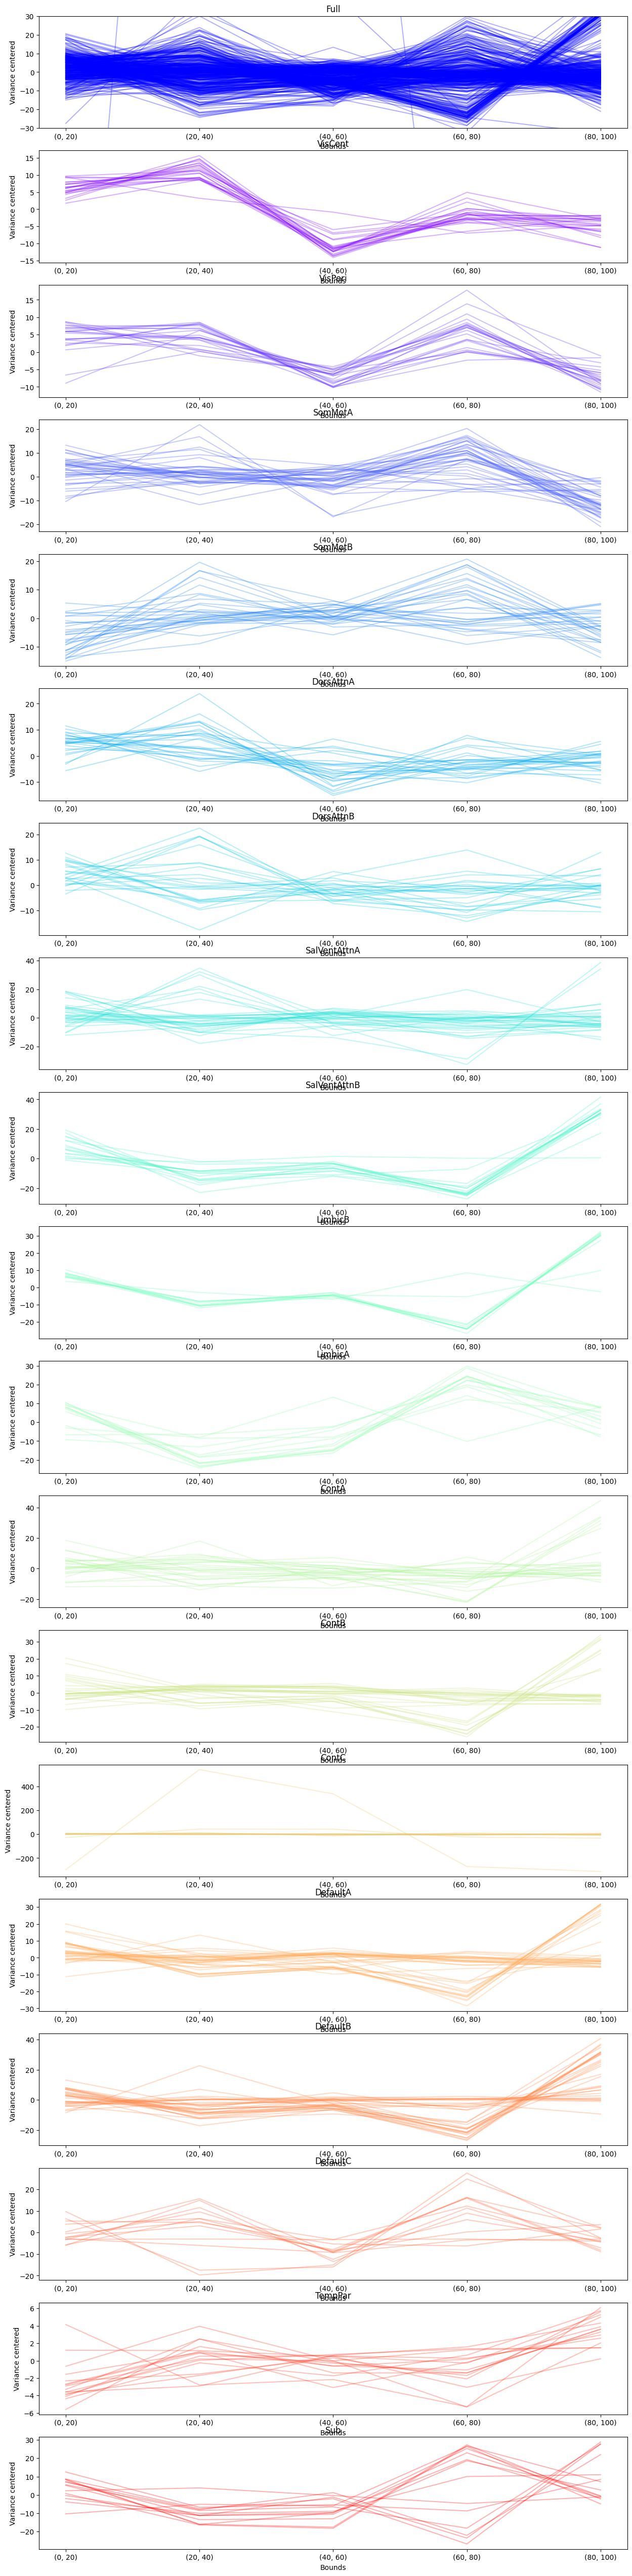

In [60]:
B = s20
perdf = np.asarray([orig_df[B].iloc[0][k] for k in range(len(orig_df[B].columns))]).T

from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, len(index2region17)))

fig, ax = plt.subplots(len(index2region17)+1,1, figsize=(15,65))
for ridx in range(len(perdf)):
    ax[0].plot(perdf[ridx]-perdf[ridx].mean(), color='b', alpha=0.3)
    ax[0].set_ylim(-30,30)
    ax[0].set_title('Full')
    ax[0].set_xticklabels([str(b) for b in B])
    ax[0].set_xticks(np.arange(0,len(B)))
    ax[0].set_xlabel('Bounds')
    ax[0].set_ylabel('Variance centered')
    
for idx,net in enumerate(index2region17):
    region_idx = index2region17[net]
    for ridx in region_idx:
        ax[idx+1].set_title(net)
        ax[idx+1].plot(perdf[ridx]-perdf[ridx].mean(), color=color[idx], alpha=0.3)
    ax[idx+1].set_xticklabels([str(b) for b in B])
    ax[idx+1].set_xticks(np.arange(0,len(B)))
    ax[idx+1].set_xlabel('Bounds')
    ax[idx+1].set_ylabel('Variance centered')
#     if net == 'DorsAttn':
#         ax[idx+1].set_ylim(-10,12)
#     if net == 'Cont':
#         ax[idx+1].set_ylim(-10,12)

<a class="anchor" id="3fa"></a>
## Frame selected (by 3FA timecourses) gradients

In [38]:
# In-Tervals percentages
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

In [39]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

threshed_series = load('./resources/fa_treshed_series.pkl')

1. Frame selection compute

In [15]:
for i in range(3):
    # individual variance variables
    fselect_subjects_gradients = {}
    
    threshed = threshed_series[i]
    for rng in tqdm(threshed.keys()):
        selected_series = threshed[rng]

        # concatenate on different frames across movies
        # basically doing reordering of columns
        tmp = next(iter(selected_series))
        subject_numbers = list(selected_series[tmp].keys())
        subject_tmpseries = {_id:[] for _id in subject_numbers}

        for mname in selected_series:
            if len(selected_series[mname]) == 0: continue
            for _id in subject_numbers:
                subject_tmpseries[_id].append(selected_series[mname][_id])

        subject_series = []
        for _id in subject_numbers:
            subject_series.append(np.concatenate(subject_tmpseries[_id]))

        # if concatenated length not long enough then skip whole process
        if len(subject_series[0]) < 15: 
            fselect_subjects_gradients[rng] = []
            continue

        # Compute individual gradients according to selected frames
        subjects_gradients = []
        for nsub in range(len(subject_numbers)):
            tmp_series = np.asarray(subject_series)[nsub]
            fc_selects = FC(tmp_series)
            g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                                kernel=aff_kernel, random_state=rs)
            g_selects.fit(fc_selects)
            subjects_gradients.append(g_selects.gradients_)

        # alignement across all gradients
        select_subjects_gradients,_,s = procrustes_align(np.asarray(subjects_gradients))
        select_subjects_gradients = np.asarray(select_subjects_gradients)
        fselect_subjects_gradients[rng] = select_subjects_gradients

    save('./resources/fselect_grads/fa_scores/fselect_subjects_gradientsFA{}.pkl'.format(i), fselect_subjects_gradients)

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

In [74]:
fselect_subjects_gradients = load('./resources/fselect_grads/fa_scores/fselect_subjects_gradientsFA2.pkl')

In [ ]:
orig_df = {}
null_df = {}
for bounds in tqdm(s5+s10+s20+s25+s33+s50):
    odf = {}
    ndf = {}
    
    lb,rb = bounds
    ssize = str(rb-lb)
    if ssize == '34': ssize='33' # ssizeck fix

    TMP = load('./resources/null_grad/sample_bins/nulldistrib_random{}.pkl'.format(ssize))
    
    A = []
    n_iter = 200

    for i in range(n_iter):
        tmp = np.asarray([D(TMP[i][bounds].mean(axis=1)[k],TMP[i][bounds][k]) for k in range(30)])
        A.append(tmp.std(axis=0))

    fscore = np.asarray([D(fselect_subjects_gradients[bounds].mean(axis=1)[k],
              fselect_subjects_gradients[bounds][k]) for k in range(30)])
    
    odf['fullnet'] = fscore.std(axis=0)
    ndf['fullnet'] = A
        
    orig_df[bounds] = odf
    null_df[bounds] = ndf

orig_df = pd.DataFrame.from_records(orig_df)
null_df = pd.DataFrame.from_records(null_df)

  0%|          | 0/44 [00:00<?, ?it/s]

#### Compute slope and locate in null distrib slope

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
nscores = {B[0][1]-B[0][0]: {} for B in [s5,s10,s20, s25, s33, s50]}

linear_coef = {B[0][1]-B[0][0]: {} for B in [s5,s10,s20, s25, s33, s50]}

for B in [s5,s10,s20, s25, s33, s50]:
    for net in index2region17.keys():
        subset = np.arange(len(B))
        # subset = [1,2]

        perdf = np.asarray([orig_df[B].iloc[0][k] for k in range(len(orig_df[B].columns))]).T
        nperdf = np.asarray([null_df[B].iloc[0][k] for k in range(len(null_df[B].columns))])
        
        # 1. Compute initial statistic
        y_train = np.concatenate([perdf[index2region17[net]][:,i] - perdf[index2region17[net]].mean(axis=1) 
                                  for i in subset])
        X_train = np.concatenate([index2region17[net].shape[0] * [i] for i in range(len(subset))])

        regressor = LinearRegression()
        regressor.fit(X_train.reshape(-1,1), y_train)
        initial_coef = regressor.coef_[0]

        intercept = regressor.intercept_
        linear_coef[B[0][1]-B[0][0]][net] = (initial_coef,intercept)
        
        # 2. Generate null statistics
        null_distrib = []
        null_intercepts = []
        n_iter = 200

        for k in range(n_iter):
            tmpdf = nperdf[:,k].T
            y_train = np.concatenate([tmpdf[index2region17[net]][:,i] - tmpdf[index2region17[net]].mean(axis=1) 
                                      for i in subset])
            X_train = np.concatenate([index2region17[net].shape[0] * [i] for i in range(len(subset))])
            regressor = LinearRegression()
            regressor.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
            null_coef = regressor.coef_[0][0]
            null_distrib.append(null_coef)
            null_intercepts.append(regressor.intercept_)

        null_distrib = np.array(null_distrib)
        null_intercepts = np.array(null_intercepts)

        # 3. Compute null score
        nscores[B[0][1]-B[0][0]][net] = null_score(null_distrib, initial_coef)

In [84]:
pd.DataFrame.from_records(nscores)

5      10     20     25     33     50
VisCent       0.000  0.000  0.000  0.045  0.100  0.015
VisPeri       0.000  0.000  0.000  0.020  0.070  0.010
SomMotA       0.195  0.290  0.355  0.185  0.115  0.045
SomMotB       0.300  0.185  0.055  0.045  0.020  0.020
DorsAttnA     0.000  0.000  0.000  0.035  0.065  0.035
DorsAttnB     0.375  0.120  0.210  0.115  0.170  0.095
SalVentAttnA  0.050  0.085  0.050  0.040  0.035  0.000
SalVentAttnB  0.270  0.205  0.230  0.260  0.230  0.055
LimbicB       0.365  0.235  0.290  0.280  0.255  0.070
LimbicA       0.295  0.370  0.080  0.110  0.050  0.090
ContA         0.080  0.070  0.120  0.175  0.185  0.085
ContB         0.245  0.200  0.335  0.300  0.245  0.080
ContC         0.140  0.205  0.240  0.095  0.290  0.085
DefaultA      0.220  0.170  0.230  0.280  0.255  0.070
DefaultB      0.305  0.195  0.265  0.270  0.235  0.060
DefaultC      0.005  0.005  0.010  0.055  0.220  0.140
TempPar       0.015  0.000  0.000  0.000  0.000  0.000
Sub           0.380  0.340  0.525  0.485  0.490  0.120

#### Visualize standard deviations

/tmp/ipykernel_58561/49198439.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([str(b) for b in B])
/tmp/ipykernel_58561/49198439.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx+1].set_xticklabels([str(b) for b in B])


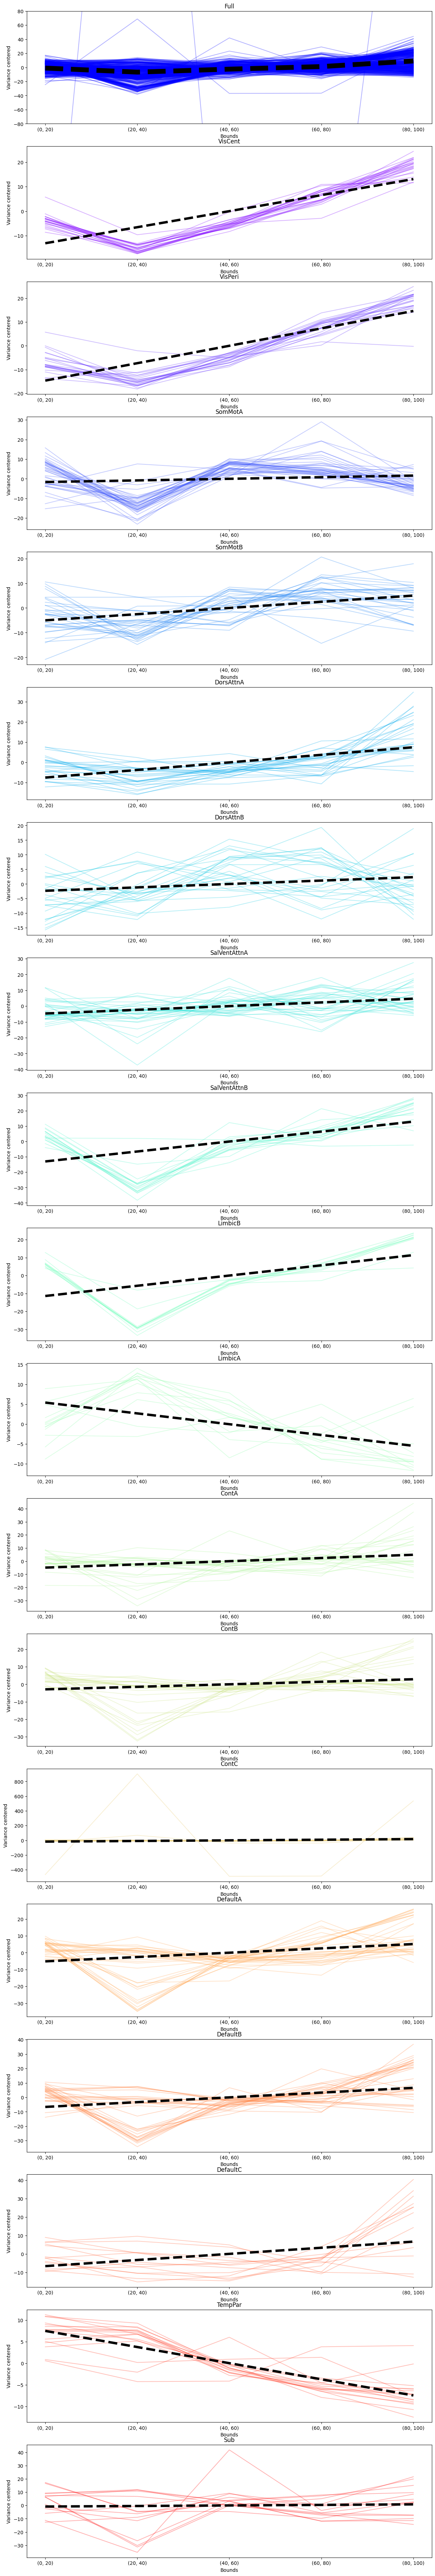

In [89]:
B = s20
ssize = B[0][1]-B[0][0]
perdf = np.asarray([orig_df[B].iloc[0][k] for k in range(len(orig_df[B].columns))]).T

from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, len(index2region17)))

fig, ax = plt.subplots(len(index2region17)+1,1, figsize=(15,95))
for ridx in range(len(perdf)):
    ax[0].plot(perdf[ridx]-perdf[ridx].mean(), color='b', alpha=0.3)
    
    ax[0].set_ylim(-80,80)
    ax[0].set_title('Full')
    ax[0].set_xticklabels([str(b) for b in B])
    ax[0].set_xticks(np.arange(0,len(B)))
    ax[0].set_xlabel('Bounds')
    ax[0].set_ylabel('Variance centered')

# plot trend
ax[0].plot(perdf.mean(axis=0) - perdf.mean(axis=0).mean(),
           color='k',linestyle='--', linewidth=10)

for idx,net in enumerate(index2region17):
    region_idx = index2region17[net]
    for ridx in region_idx:
        ax[idx+1].set_title(net)
        ax[idx+1].plot(perdf[ridx]-perdf[ridx].mean(), color=color[idx], alpha=0.3)

    a,b = linear_coef[ssize][net]
    # plot trend
    ax[idx+1].plot(a*np.arange(len(B)) + b,
                   color='k',linestyle='--', linewidth=5)

    
    ax[idx+1].set_xticklabels([str(b) for b in B])
    ax[idx+1].set_xticks(np.arange(0,len(B)))
    ax[idx+1].set_xlabel('Bounds')
    ax[idx+1].set_ylabel('Variance centered')
#     if net == 'DorsAttn':
#         ax[idx+1].set_ylim(-10,12)